In [ ]:
%load_ext autoreload
%autoreload 2
import sys
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
import sasc.viz
import joblib
import dvu
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import brain_drive_resps_dir, repo_dir
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
flatmaps_per_question = __import__('06_flatmaps_per_question')

### load average flatmaps per explanation braindrive

In [ ]:
brain_drive_avgs_pilot = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot.pkl'))
brain_drive_avgs_pilot5 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot5.pkl'))
brain_drive_avgs = brain_drive_avgs_pilot | brain_drive_avgs_pilot5

### load weights for jointly fitted 35-question model

In [ ]:
# # load questions model weights
# results_dir = analyze_helper.best_results_dir
# rr, cols_varied, mets = analyze_helper.load_clean_results(results_dir)
# metric_sort = 'corrs_tune_pc_weighted_mean'

# # pick model to interpret
# r = rr
# r = r[r.qa_questions_version == 'v3_boostexamples_merged']
# r = r[r.num_stories == -1]
# r = r[r.weight_enet_mask_num_nonzero == 35]
# r = r[r.feature_space == 'qa_embedder']
# cols_varied = [c for c in cols_varied if not c in ['num_stories',
#                                                    'feature_selection_alpha', 'feature_selection_stability_seeds']]
# args0 = r[r.subject == 'S02'].iloc[0]
# weights, weights_pc = flatmaps_per_question.get_weights_top(args0)
# qs_selected = questions[args0['weight_enet_mask']]
# df_w_selected35 = pd.DataFrame({'question': qs_selected, 'weights': [
#                     w for w in weights]}).set_index('question')
# joblib.dump((args0, qs_selected, df_w_selected35),
# '../qa_results/processed/selected_weights.pkl')

args0, qs_selected, df_w_selected35 = joblib.load(
    '../qa_results/processed/selected_weights.pkl')

### load weights for individual question models

In [ ]:
results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/jun16_gpt4'
rr, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

In [ ]:
r = rr
r = r[r.subject == 'S02']
r = r[r.use_added_wordrate_feature == 0]
r = r[r.feature_space == 'qa_embedder']

weights = np.array([
    flatmaps_per_question.get_weights_top(r.iloc[i])[0]
    for i in tqdm(range(len(r)))
]).squeeze()
qs_selected = r['qa_questions_version']
df_w_individual = pd.DataFrame({'question': qs_selected, 'weights': [
    w for w in weights]}).set_index('question')
joblib.dump((r, qs_selected, df_w_individual),
            '../qa_results/processed/individual_weights.pkl')
r, qs_selected, df_w_individual = joblib.load(
    '../qa_results/processed/individual_weights.pkl')

### load weights for individual question models **with wordrate**

In [ ]:
r = rr
r = r[r.subject == 'S02']
r = r[r.use_added_wordrate_feature == 1]
r = r[r.feature_space == 'qa_embedder']

weights = np.array([
    flatmaps_per_question.get_weights_top(r.iloc[i])[0]
    for i in tqdm(range(len(r)))
])[:, 0, :].squeeze()
qs_selected = r['qa_questions_version']
df_w_individual_wordrate = pd.DataFrame({'question': qs_selected, 'weights': [
    w for w in weights]}).set_index('question')
joblib.dump((r, qs_selected, df_w_individual_wordrate),
            '../qa_results/processed/individual_weights_wordrate.pkl')
r, qs_selected, df_w_individual_wordrate = joblib.load(
    '../qa_results/processed/individual_weights_wordrate.pkl')

### load weights for just wordrate

In [ ]:
r = rr
r = r[r.subject == 'S02']
r = r[r.use_added_wordrate_feature == 0]
r = r[r.feature_space == 'wordrate']

weights = flatmaps_per_question.get_weights_top(r.iloc[0])[0]
qs_selected = list(rr['qa_questions_version'].unique())
df_w_wordrate_alone = pd.DataFrame({'question': qs_selected, 'weights': [
    weights for i in range(len(qs_selected))]}).set_index('question')
joblib.dump((r, qs_selected, df_w_wordrate_alone),
            '../qa_results/processed/weights_wordrate_alone.pkl')
r, qs_selected, df_w_wordrate_alone = joblib.load(
    '../qa_results/processed/weights_wordrate_alone.pkl')

### Make comparison

In [ ]:
# matches
qa_list = [
    # approx matches
    'Is time mentioned in the input?',
    'Does the input contain a measurement?',
    # 'Does the input contain a number?',
    'Does the sentence mention a specific location?',
    # 'Does the sentence describe a relationship between people?',
    # 'Does the sentence describe a relationship between people?',
    'Does the text describe a mode of communication?',
    # 'Does the sentence contain a negation?',
]
bd_list = [
    # approx matches
    ('time', 212),
    ('measurements', 171),
    # ('measurements', 171),
    # ('moments',	337),
    # ('locations', 122),
    ('locations', 368),
    # ('emotion', 179),
    # ('emotional expression', 398),
    ('communication', 299),
    # ('negativity', 248)
]


qa_list += [
    'Is the sentence abstract rather than concrete?',
    'Does the sentence contain a cultural reference?',
    'Does the sentence include dialogue?',
    'Is the input related to a specific industry or profession?',
    'Does the sentence contain a negation?',
    'Does the input contain a number?',
    "Does the sentence express the narrator's opinion or judgment about an event or character?",
    'Does the sentence describe a personal or social interaction that leads to a change or revelation?',
    'Does the sentence describe a personal reflection or thought?',
    'Does the sentence involve an expression of personal values or beliefs?',
    'Does the sentence describe a physical action?',
    'Does the input involve planning or organizing?',
    'Does the sentence contain a proper noun?',
    'Does the sentence describe a relationship between people?',
    'Does the sentence describe a sensory experience?',
    'Does the sentence involve the mention of a specific object or item?',
    'Does the sentence include technical or specialized terminology?',
]

bd_list += [
    ('abstract descriptions', 'qa'),
    ('cultural references', 'qa'),
    ('dialogue', 'qa'),
    ('industry or profession', 'qa'),
    ('negations', 'qa'),
    ('numbers', 'qa'),
    ('opinions or judgments', 'qa'),
    ('personal or interactions interactions', 'qa'),
    ('personal reflections or thoughts', 'qa'),
    ('personal values or beliefs', 'qa'),
    ('physical actions', 'qa'),
    ('planning or organizing', 'qa'),
    ('proper nouns', 'qa'),
    ('relationships between people', 'qa'),
    ('sensory experiences', 'qa'),
    ('specific objects or items', 'qa'),
    ('technical or specialized terminology', 'qa')]

df_pairs = pd.DataFrame({
    'qa_weight': qa_list,
    'bd_avg_resp': bd_list,
})

# average weights for df_w_selected35 and df_w_individual
df_avg = df_w_selected35.merge(df_w_individual, on='question')
df_avg['weights'] = df_avg.apply(
    lambda x: np.mean([x['weights_x'], x['weights_y']], axis=0), axis=1)

df_qa_dict = {
    'selected35': df_w_selected35,
    'individual': df_w_individual,
    'individual_wordrate': df_w_individual_wordrate,
    'wordrate_alone': df_w_wordrate_alone,
    'avg': df_avg,
}

/home/chansingh/fmri/qa_results/hypothesis_tests/individual


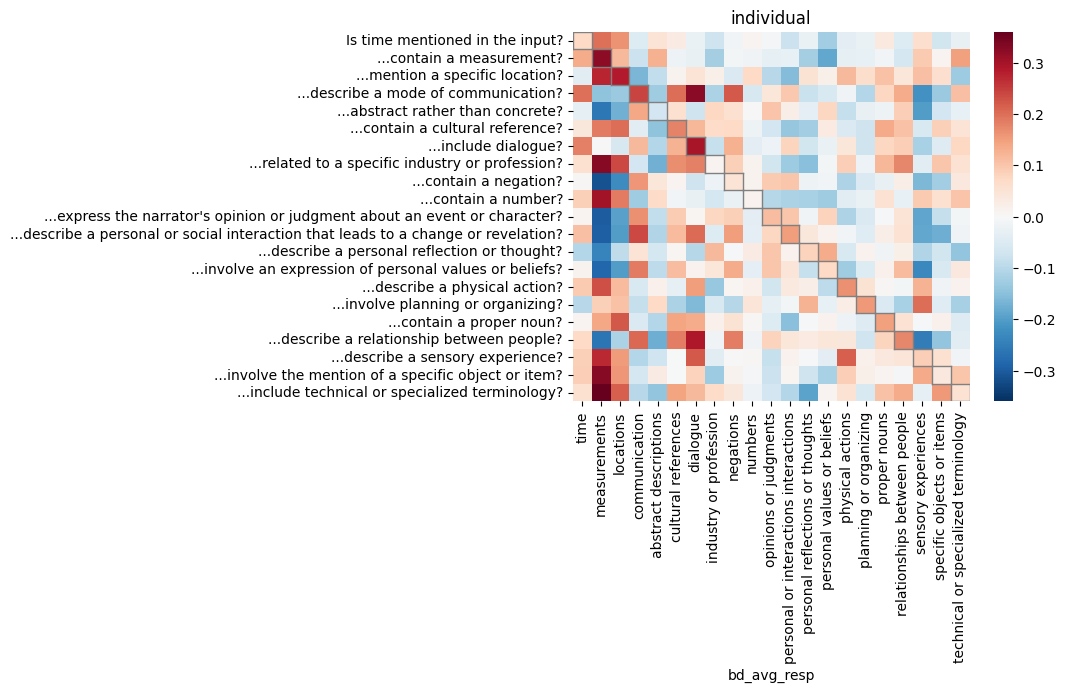

100%|██████████| 21/21 [00:48<00:00,  2.33s/it]


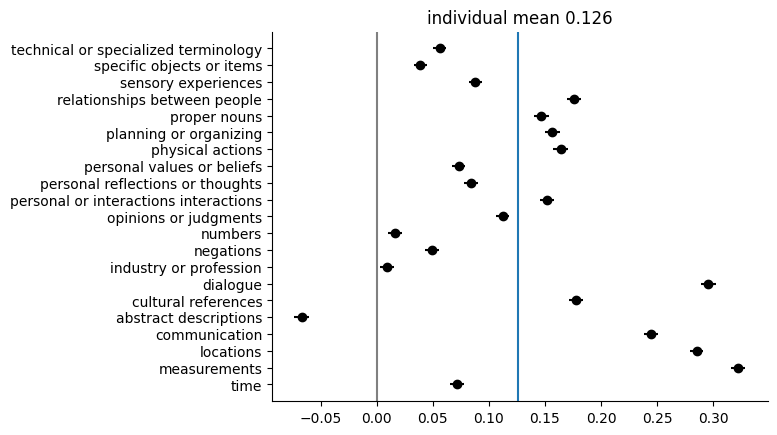

In [31]:


def corr_plots(wt_qas, wt_bds, out_dir_save, setting: str):
    os.makedirs(out_dir_save, exist_ok=True)
    print(out_dir_save)
    # mask = args0['corrs_test'] >= 0
    # wt_qas = [wt_qa[mask] for wt_qa in wt_qas]
    # wt_bds = [wt_bd[mask] for wt_bd in wt_bds]

    corrs = pd.DataFrame(
        np.zeros((len(wt_qas), len(wt_bds))),
        columns=df_pairs['bd_avg_resp'].apply(lambda x: x[0]).astype(str),
        # [f'{bd_list[i][0]}_{bd_list[i][1]}'.replace('_qa', '') for i in range(len(bd_list))],
        index=[analyze_helper.abbrev_question(
            q) for q in df_pairs['qa_weight'].astype(str)],
        # index=df_pairs['qa_weight'].astype(str),
    )
    for i, qa in enumerate(df_pairs['qa_weight']):
        for j, bd in enumerate(df_pairs['bd_avg_resp']):
            corrs.iloc[i, j] = np.corrcoef(wt_qas[i], wt_bds[j])[0, 1]

    # normalize each column
    # corrs = corrs / corrs.abs().max()
    # normalize each row to mean zero stddev 1
    # corrs = (corrs - corrs.mean()) / corrs.std()
    # plt.figure(figsize=(20, 10))
    vmax = np.max(np.abs(corrs.values))
    # sns.clustermap(corrs, annot=False, cmap='RdBu', vmin=-vmax, vmax=vmax, dendrogram_ratio=0.01)

    sns.heatmap(corrs, annot=False, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    plt.title(setting)
    # plt.imshow(corrs, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    # plt.xticks(range(len(bd_list)), [f'{bd[0]}' for bd in bd_list], rotation=90)
    # plt.yticks(range(len(qa_list)), qa_list)
    # plt.colorbar()
    dvu.outline_diagonal(corrs.values.shape, roffset=0.5, coffset=0.5)
    plt.savefig(join(out_dir_save, 'corrs_heatmap.pdf'), bbox_inches='tight')
    plt.show()

    # barplot of diagonal
    def _get_func_with_perm(x1, x2, n=300, perc=95):
        corr = np.corrcoef(x1, x2)[0, 1]
        corrs_perm = [
            np.corrcoef(np.random.permutation(x1), x2)[0, 1]
            for i in range(n)
        ]
        # print(corrs_perm)
        return corr, np.percentile(corrs_perm, 50-perc/2), np.percentile(corrs_perm, 50+perc/2)

    corrs_mean = []
    corrs_err = []
    for i in tqdm(range(len(corrs.columns))):
        corr, corr_interval_min, corr_interval_max = _get_func_with_perm(
            wt_qas[0], wt_bds[0])
        corrs_mean.append(corr)
        corrs_err.append((corr_interval_max - corr_interval_min)/2)
    # sns.barplot(y=corrs.columns, x=np.diag(corrs), color='gray')
    plt.errorbar(np.diag(corrs), range(len(corrs.columns)),
                 xerr=corrs_err, fmt='o', color='black')
    plt.yticks(range(len(corrs.columns)), corrs.columns)
    plt.axvline(0, color='gray')

    plt.axvline(np.diag(corrs).mean())
    plt.title(f'{setting} mean {np.diag(corrs).mean():.3f}')
    plt.savefig(join(out_dir_save, 'corrs_barplot.pdf'), bbox_inches='tight')
    plt.show()


# for setting in df_qa_dict.keys():
for setting in ['individual']:
    df_qa_weights = df_qa_dict[setting]
    df_pairs = df_pairs[df_pairs['qa_weight'].isin(df_qa_weights.index)]
    wt_qas = df_qa_weights.loc[df_pairs['qa_weight'].values]['weights'].values
    wt_bds = [brain_drive_avgs[bd] for bd in df_pairs['bd_avg_resp'].values]
    corr_plots(wt_qas, wt_bds, join(
        repo_dir, 'qa_results', 'hypothesis_tests', setting), setting)

In [ ]:
# quickshow(wt_qas[0])
# quickshow(wt_bds[0])
sasc.viz.quickshow(
    wt_qas[0],
    subject="UTS02",
)

In [ ]:
wt_qas[0].shape